
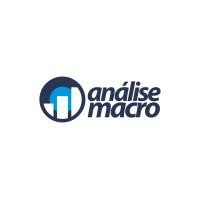

##**<center>Ciência de Dados para Economia e Finanças</center>**



---


**<center>Modelo de Previsão da Inflação medida pelo IPCA</center>**

**<center>Vítor Wilher, Cientista-Chefe</center>**




**<center>Exercício proposto</center>**



---



A Análise Macro foi contratada por uma Gestora de Recursos para automatizar o processo de previsão da inflação brasileira medida pelo Índice de Preços ao Consumidor Amplo (IPCA). Espera-se que todo o processo de construção seja detalhado em etapas de coleta, tratamento, modelagem e apresentação dos resultados.

   Serão particularmente avaliados as etapas de extração automatizada e a acurácia dos modelos propostos, que
deve ser explicitada ao longo do processo, bem como a metodologia utilizada, que deve ser explicitada em
referências bibliográficas detalhadas.



*   Você deve escrever o script e a apresentação em Python.
*   Você deve entregar o output do modelo de forma gráfica e em tabela, de preferência utilizando um dashboard
para isso.
* Para executar o projeto, você tem uma semana a partir do recebimento desse e-mail.
* São bem-vindos um código limpo e conciso, bem como uma boa documentação de cada etapa do projeto.






#Bibliotecas

##Importando Bibliotecas

In [1]:
# Úteis 
import datetime as dt
from datetime import timedelta

#Manipulação de Dados
import pandas as pd
import numpy as np
from math import sqrt

#Visualização de Dados
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ='retina'   # Plots de alta resolução

# Filtrar warnings
import warnings
warnings.filterwarnings('ignore');

#Aprendizado de Maquinas
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Etapa 01 - Coleta de Dados

Todos os dados foram retirados do [Time Series Management System](https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries). Esses dados são oficiais do Banco Central do Brasil.

Nesse [link](https://dadosabertos.bcb.gov.br/dataset/20542-saldo-da-carteira-de-credito-com-recursos-livres---total/resource/6e2b0c97-afab-4790-b8aa-b9542923cf88) existe o método para coletar essas informações em formato JSON. Iremos usar a biblioteca [PANDAS](https://pandas.pydata.org/) para trabalhar com os dados antes de apresenta-los de forma grafica.


## 1.1 - Obtendo dados do Banco Central do Brasil

A constante CODIGO_SERIE = 433 representa o codigo do IPCA no Banco Central do Brasil(BCB). Apenas substituindo esse código conseguimos coletar outros dados do BCB, como IGMP, CELIC, RESERVAS INTERNACIONAIS, PNAD, CDI, etc.

In [ ]:
CODIGO_SERIE = 433
def query_bcb(CODIGO_SERIE):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(CODIGO_SERIE)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)#Alterando coluna para DateTime
  df.set_index('data', inplace=True)#Alterando Coluna data para Index
  return df

#Etapa 02 - Tratamento dos Dados

A etapa de tratamento dos Dados consiste na varredura de toda a base de dados, tratando dados nulos, corrigindo tipos de dados e criando novas colunas que serão usadas no treino do modelo de predição.

## 2.1 - Criando DataFrame

In [ ]:
#Criando data frame à partir da função
ipca_df = query_bcb(CODIGO_SERIE)

#Filtrando data frame por data
ipca_df = ipca_df['2002':'2022']

## 2.2 - Verificando DataFrame

In [ ]:
#Tipo de dados do Data Frame
ipca_df.dtypes

valor    float64
dtype: object

In [ ]:
print('Nossa base de dados contém',ipca_df.isna().sum().sum(), 'valores nulos')

Nossa base de dados contém 0 valores nulos


In [ ]:
#Criando Colunas com valores anteriores
ipca_df['mes_anterior'] = ipca_df['valor'].shift(+1)
ipca_df['dois_meses_anteriores'] = ipca_df['valor'].shift(+2)
ipca_df['tres_meses_anteriores'] = ipca_df['valor'].shift(+3)

#Excluindo linhas com valores nulos
ipca_df = ipca_df.dropna()

In [ ]:
#Amostra do Data Frame
ipca_df.sample(5)

,valor,mes_anterior,dois_meses_anteriores,tres_meses_anteriores
data,,,,
2003-04-01,0.97,1.23,1.57,2.25
2003-09-01,0.78,0.34,0.20,-0.15
2009-03-01,0.20,0.55,0.48,0.28
2022-09-01,-0.29,-0.36,-0.68,0.67
2014-11-01,0.51,0.42,0.57,0.25


In [ ]:
ipca_df.shape

(246, 4)

## 2.3 - Visualização Gráfica

A vizualição grafica apresentado nesse projeto consiste em três informações basicas, consideradas relevantes para a análise dos dados. 



* Grafico 2.3.1 : Grafico de linha representando a evolução da taxa IPCA entre o ano 2002 e 2022.
* Grafico 2.3.2 : Histograma apresentando a distribuição e frequencia da taxa de juro no mesmo período.
* Grafico 2.3.3 : Grafico Boxplot para identificar outlier e mostrar alguns valores estatistico de quartis e mediana.






###Gráfico de linha (2.3.1)

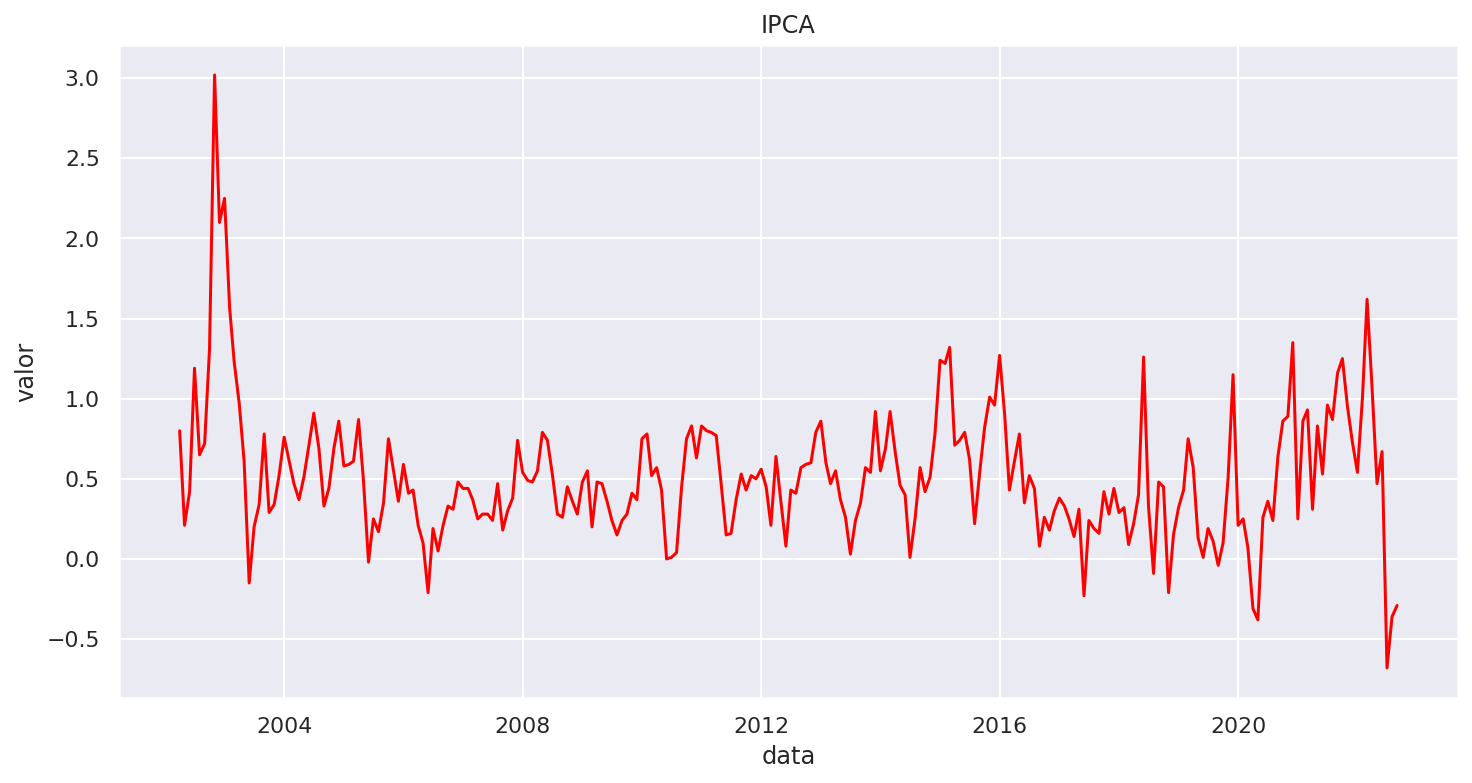

In [ ]:
#Criando Grafico de Linha com Dados Historicos
plt.subplots(figsize=(12, 6))
line_plot = sns.lineplot(data=ipca_df,x='data',y='valor',color='red')
line_plot.set_title('IPCA')
plt.show(line_plot)

###Histograma (2.3.2)

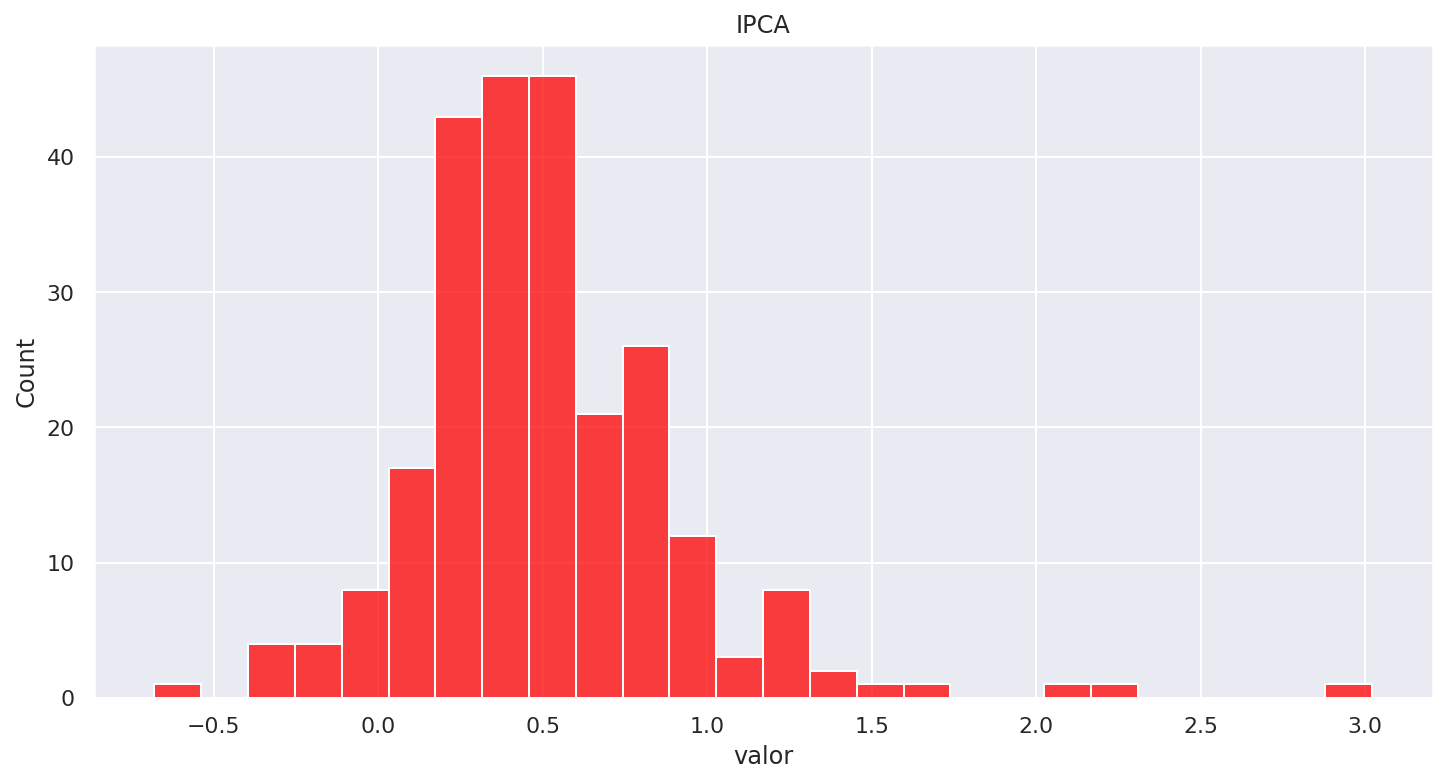

In [ ]:
#Criando Histograma com Dados Historicos
plt.subplots(figsize=(12, 6))
line_plot = sns.histplot(data=ipca_df,x='valor',color='red')
line_plot.set_title('IPCA')
plt.show(line_plot)

###Grafico BoxPlot (2.3.3)

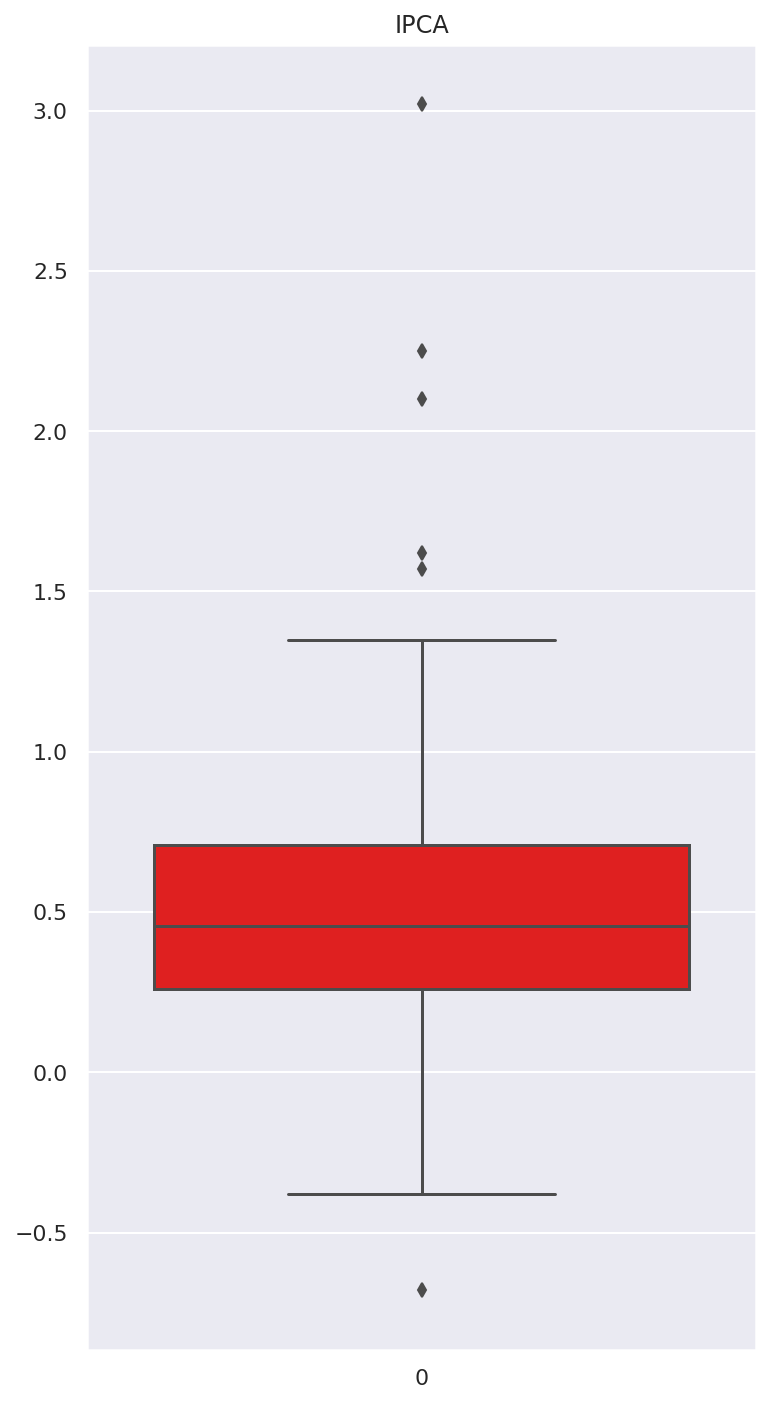

In [ ]:
plt.subplots(figsize=(6, 12))
box_plot = sns.boxplot(data=ipca_df['valor'],color='red')
box_plot.set_title('IPCA')
plt.show(box_plot)

# Etapa 03 - Modelagem

As etapas a seguir definirão o modelo usado para predição dos valores, assim como treino e teste do modelo citado.

Foram selecionados dois modelos para os testes:

## 3.1 - [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

[RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) é um estimador que ajusta várias arvores de decisão de classificação e usa a média para melhorar a precisão do modelo.

Foi definido 3 parametros para a execução do modelo:
* ***n_estimators*** = Limita o numero de arvores de decisão.
* ***max_features*** = O número de features a serem considerados ao procurar a melhor divisão.
* ***random_state*** = Controla tanto a aleatoriedade do bootstrap das amostras usadas ao construir árvores  quanto a amostragem dos recursos a serem considerados ao procurar a melhor divisão em cada nó .

In [ ]:
model=RandomForestRegressor(n_estimators=100,max_features=3, random_state=1)

## 3.2 - [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

[LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) ajusta um modelo linear com coeficientes w = (w1, …, wp) para minimizar a soma residual dos quadrados entre os alvos observados no conjunto de dados e os alvos previstos pela aproximação linear.

In [ ]:
lin_model=LinearRegression()

In [ ]:
#Criando Array com valor dos meses anteriores atribuidos a X e alvo atribuido a Y
x1,x2,x3,y = ipca_df['mes_anterior'],ipca_df['dois_meses_anteriores'],ipca_df['tres_meses_anteriores'],ipca_df['valor']
x1,x2,x3,y=np.array(x1),np.array(x2),np.array(x3),np.array(y)
x1,x2,x3,y=x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),y.reshape(-1,1)
final_x=np.concatenate((x1,x2,x3),axis=1)


* X_train = Variavel preditora (Treino)
* X_test = Variavel preditora (Teste)
* y_train = Variavel Alvo para predição (Treino)
* y_test = Variavel Alvo para predição (Teste)

In [ ]:
#Separando 80% dos dados para treino e 20% para teste
X_train,X_test,y_train,y_test=final_x[:-50],final_x[-50:],y[:-50],y[-50:]

In [ ]:
print("Tamanho da variavel preditora de treino: ",X_train.shape)
print("Tamanho da variavel preditora de teste: ",X_test.shape)
print("Tamanho da variavel alvo de treino: ",y_train.shape)
print("Tamanho da variavel alvo de treino: ",y_test.shape)

## 3.3 - Treino

Para instanciar os modelos definidos anteriormente é preciso usar a variavei preditora de treino (X_train) e a variavel alvo (y_train).

In [ ]:
model.fit(X_train,y_train)
lin_model.fit(X_train,y_train)

# Etapa 04 - Apresentação dos Resultados

## 4.1 - RandomForestRegressor

### 4.1.1 - Visualização Grafica

In [ ]:
pred=model.predict(X_test)

plt.rcParams["figure.figsize"] = (12,8)
plt.plot(pred,label='Arvore de decisões aleatória')
plt.plot(y_test,label='Preço Real')
#Posicionando Legenda
plt.legend(loc="upper left")
plt.show()

### 4.1.2 - Visualização em tabela

In [ ]:
#Gerando arquivo Excel dos resultados preditos
new_df = ipca_df.reset_index().tail(50).reset_index()
pred_df = pd.DataFrame(pred,columns=['RFR'])
df = new_df.join(pred_df)
df = df.drop(columns='index')
df.to_excel('RFR.xlsx')

##4.2 - LinearRegression

### 4.2.1 - Visualizaçao Grafica

In [ ]:
lin_pred=lin_model.predict(X_test)

plt.rcParams["figure.figsize"] = (11,6)
plt.plot(lin_pred,label='Regreção Linear')
plt.plot(y_test,label='Preço Atual')
#Posicionando Legenda
plt.legend(loc="upper left")
plt.show()

### 4.2.2 - Visualização em tabela

In [ ]:
new_df = ipca_df.reset_index().tail(50).reset_index()
lin_pred_df = pd.DataFrame(pred,columns=['RL'])
df = new_df.join(lin_pred_df)
df = df.drop(columns='index')
df.to_excel('LR.xlsx')

##4.3 - [Mean Squared Error (MSE)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)

A mean_squared_errorfunção calcula o erro quadrático médio , uma métrica de risco correspondente ao valor esperado do erro quadrático (quadrático) ou perda.

In [ ]:
#MSE RandomForestRegressor
rmse_rf=sqrt(mean_squared_error(pred,y_test))
#MSE LinearRegression
rmse_lr=sqrt(mean_squared_error(lin_pred,y_test))

print('MSE RandomForestRegressor:',rmse_rf)
print('MSE LinearRegression:',rmse_lr)

#Etapa 06 - Predição Futura

Essa etapa executamos a predição do proximo mês levando como analise os meses anteriores.

In [ ]:
#Criando array
proximo_mes = np.array([final_x[-1][0],final_x[-1][1],final_x[-1][2]])

#Executando predição
model_v2 = model.fit(X_train, y_train)
prox = model_v2.predict(proximo_mes.reshape(1, -1))

print("Valor predito do proximo mês: ",float(prox))

#Conclusão

Analisando os dois modelos propostos é observavel a melhor precisão no modelo de Regressão linear, onde a diferença entre a predição e os dados reais são relativamente pequenas.

O modelo de Random Forest Regressor apresenta um resultado aceitável considerando que o modelo parte de um dado aleatório e só após isso os dados são refinados e aproximados aos dados reais.

#Referencias




##[ Mean Square Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)




Documentação Mean Square Error.

##[Regressão Linear](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)


Documentação Scikit Learn sobre Regressão Linear.

##[Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)


Documentação Scikit Learn sobre Random Forest Regressor.

##[Pandas](https://pandas.pydata.org/docs/user_guide/index.html)

Documentação oficial Pandas.

## Data Science do Zero

GRUS, Joeal. Data Science do Zero : Noções Fundamentais com Python.Segunda Edição. Rio de Janeiro, 2021.